In [1]:
import os

# takes care of annoying TF-GPU warnings
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# remove useless Tensorflow warning:
# WARNING:absl:Found untraced functions such as _update_step_xla, lstm_cell_1_layer_call_fn, 
# lstm_cell_1_layer_call_and_return_conditional_losses, lstm_cell_2_layer_call_fn, 
# lstm_cell_2_layer_call_and_return_conditional_losses while saving (showing 5 of 5). 
# These functions will not be directly callable after loading.
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [2]:
# very useful for managing wandb runs: https://stackoverflow.com/questions/71106179/log-two-model-runs-with-keras-wandb
import wandb
from wandb.keras import WandbCallback

os.environ["WANDB_SILENT"] = "true"

#### RNN: Formula Label Prediction 

In [3]:
import numpy as np 
import pandas as pd
from pathlib import Path 

import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_text as tf_text

#from tf.keras.callbacks import tensorboard_callback

import datetime

tfds.disable_progress_bar()
wandb_project_name = "binary_formula_classification"

In [4]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./tmp/tfdbg2_logdir")
"""
tf.debugging.experimental.enable_dump_debug_info(
    "./tmp/tfdbg2_logdir",
    tensor_debug_mode="FULL_HEALTH",
    circular_buffer_size=-1)
"""

'\ntf.debugging.experimental.enable_dump_debug_info(\n    "./tmp/tfdbg2_logdir",\n    tensor_debug_mode="FULL_HEALTH",\n    circular_buffer_size=-1)\n'

In [5]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_"+metric], "")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, "val_"+metric])

#### Import Data and Preprocess Dataframe

In [6]:
def preprocess_data(corpus,
                    irrelevant_features=["mtype",]):
    # drop irrelevant columns
    corpus.drop(irrelevant_features, inplace=True, axis=1)

    # filter strings
    def process_cell(cell_str):
        stripped_f_str = cell_str[1:-1].replace("\\\\", "\\")
        f_list = stripped_f_str.split(",")
        f_list = [token.replace("'", "").replace(" ", "") for token in f_list]
        f_list = ["{" if token == "\\{" else token for token in f_list]
        f_list = ["}" if token == "\\}" else token for token in f_list]
        cell_str = " ".join(f_list)
        return cell_str

    corpus["tokens"] = corpus["tokens"].map(process_cell)

In [7]:
#print(os.getcwd())
data_p = Path("../data/") / "bin_class_data_TOKENIZED_SET_V1.csv"
data = pd.read_csv(data_p)
preprocess_data(data)
data.head()


,tokens,type_tokens,label
0,f : A \to B,"['func_def', 'func_name', '__ANON_1', 'COLON',...",1
1,f,"['func_name', '__ANON_1']",1
2,g \colon B \to I,"['func_def', 'func_name', '__ANON_1', 'COLON',...",1
3,\frac { 8 ! } { ( 8 - 4 ) ! },"['expr_atom', 'CMD_FRAC', 'L_BRACE', 'postfix'...",1
4,f,"['func_name', '__ANON_1']",1


In [8]:
SIZE_TRAIN_DS = 10000
SIZE_TEST_DS = 1000
data_as_ds = tf.data.Dataset.from_tensor_slices((data["tokens"], data["label"])) 
test_dataset = data_as_ds.take(SIZE_TEST_DS)
train_dataset = data_as_ds.skip(SIZE_TEST_DS)

##### Setup and Data Preparation

In [9]:
for example, label in train_dataset.take(3):
    print("text: ", example.numpy())
    print("label: ", label.numpy())

text:  b'f'
label:  1
text:  b'f'
label:  1
text:  b'f : X \\rightarrow Y'
label:  1


In [10]:
BUFFER_SIZE = SIZE_TRAIN_DS
BATCH_SIZE = 64
STEPS_PER_EPOCH = np.floor(SIZE_TRAIN_DS/BATCH_SIZE)
VAL_STEPS_PER_EPOCH = np.floor(SIZE_TEST_DS/BATCH_SIZE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

##### Text Encoding

In [11]:
def create_encoder(output_mode_str, n_grams):
    VOCAB_SIZE = 1000
    encoder = tf.keras.layers.TextVectorization(
        standardize=None,
        output_mode=output_mode_str,
        ngrams = n_grams,
        split="whitespace",
        max_tokens=VOCAB_SIZE)
    encoder.adapt(train_dataset.map(lambda tokens, label: tokens)) # removes the label column through transformation: text, label -> text
    return encoder

##### Representation 1: Use integer indices encoding

In [12]:
encoder_int = create_encoder("int", None)
vocab = np.array(encoder_int.get_vocabulary())
vocab[:200]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


array(['', '[UNK]', 'f', '1', '2', 'x', '}', '{', ':', '^', '(', ')', '0',
       '\\to', '+', '3', 'A', '-', 'g', 'n', 'B', '4', 'a', 'X', '=', '5',
       '\\rightarrow', 'b', '6', 'Y', '7', '\\frac', '\\mathbb', '9',
       '\\mathbb{N}', '\\mathbb{R}', 'h', '8', 'y', 'R', '\\colon', 'N',
       'S', 'c', 'F', '\\times', 'p', 'k', 'm', '/', 'C', 'i', 't', 'd',
       'z', 'e', 's', ']', '[', 'q', '\\mathbb{Z}', '\\cup', 'mathbb{N',
       '\\cap', 'r', '\\cdot', 'T', '\\dfrac', '!', '\\circ', 'P', 'Z',
       'D', 'varnothin', 'u', 'I', 'G', 'Q', 'co', 'E', 'M',
       '\\mathbb{Q}', 'si', 'mathbb{R', 'U', '*', 'mathbb{Z', 'j', 'V',
       'H', 'v', 'W', 'o', 'l', '\\varnothing)', 'Token(sets__SET_EMPTY',
       'w', 'K', 'mathbb{Q', 'L', '\\mathbb{C}', 'ta', 'arcta', 'arcsi',
       'J', '\\varnothing', '\\binom', 'lo', 'ex', 'O', 'arcco', '\\sin',
       '\\exp', 'sin', '\\tfrac', '\\tanh', '\\cos', 'mathbb{C',
       'mathbb{A', 'cos', '\\sec', '\\arctan', '\\arcsin'], dtype='<U2

In [13]:
encoded_example = encoder_int(example).numpy()
print(example)
print(encoded_example)
print(encoded_example.shape)
print(label.shape)

tf.Tensor(b'f : X \\rightarrow Y', shape=(), dtype=string)
[ 2  8 23 26 29]
(5,)
()


In [14]:
print("Original: ", example.numpy())
print("After reverse lookup: ", " ".join(vocab[encoded_example]))

Original:  b'f : X \\rightarrow Y'
After reverse lookup:  f : X \rightarrow Y


In [15]:
#inputter = tf.keras.layers.Input(shape=(len(encoder_int.get_vocabulary()),) ,batch_size = 1)
#pooled_val = tf.reshape(embedded_val, [val1*val2, 1])
#encoded_example = tf.reshape(encoded_example, [1,len(encoder_int.get_vocabulary())-1])
#print(encoded_example)

In [16]:
"""
embedder = tf.keras.layers.Embedding(
            input_dim=len(encoder_int.get_vocabulary()),
            output_dim=64,
            # user masking to handle the variable sequence lengths
            mask_zero=True)
embedded_val = embedder(encoded_example)
print(embedded_val)
embedded_val = tf.reshape(embedded_val, [1,122,64])
#print(embedded_val.shape)
"""

'\nembedder = tf.keras.layers.Embedding(\n            input_dim=len(encoder_int.get_vocabulary()),\n            output_dim=64,\n            # user masking to handle the variable sequence lengths\n            mask_zero=True)\nembedded_val = embedder(encoded_example)\nprint(embedded_val)\nembedded_val = tf.reshape(embedded_val, [1,122,64])\n#print(embedded_val.shape)\n'

In [17]:
"""
flatter = tf.keras.layers.Flatten(input_shape=(122, 64))
flattened = flatter(embedded_val)
print(flattened.shape)
"""

'\nflatter = tf.keras.layers.Flatten(input_shape=(122, 64))\nflattened = flatter(embedded_val)\nprint(flattened.shape)\n'

In [18]:
#val1, val2 = embedded_val.shape
#pooled_val = tf.reshape(embedded_val, [val1*val2, 1])
#print(pooled_val)
#pooled_val = tf.reshape(embedded_val, [122, ])

In [19]:
#denser = tf.keras.layers.Dense(1, activation="sigmoid")
#denser_val = denser(pooled_val)
#print(denser_val)

##### Representation 2: Binary Count Vectorizer

In [20]:
encoder_multi_hot = create_encoder("multi_hot", None)
vocab = np.array(encoder_multi_hot.get_vocabulary())
vocab[:200]

array(['[UNK]', 'f', '1', '2', 'x', '}', '{', ':', '^', '(', ')', '0',
       '\\to', '+', '3', 'A', '-', 'g', 'n', 'B', '4', 'a', 'X', '=', '5',
       '\\rightarrow', 'b', '6', 'Y', '7', '\\frac', '\\mathbb', '9',
       '\\mathbb{N}', '\\mathbb{R}', 'h', '8', 'y', 'R', '\\colon', 'S',
       'N', 'c', 'F', '\\times', 'p', 'k', 'm', '/', 'C', 't', 'i', 'd',
       'z', 'e', 's', ']', '[', 'q', '\\mathbb{Z}', '\\cup', 'mathbb{N',
       '\\cap', 'r', '\\cdot', 'T', '\\dfrac', '!', '\\circ', 'P', 'D',
       'Z', 'varnothin', 'u', 'I', 'G', 'Q', 'co', 'E', 'M',
       '\\mathbb{Q}', 'si', 'mathbb{R', 'U', '*', 'mathbb{Z', 'j', 'V',
       'H', 'v', 'W', 'o', 'l', '\\varnothing)', 'Token(sets__SET_EMPTY',
       'w', 'K', 'mathbb{Q', 'L', 'arcta', '\\mathbb{C}', 'ta', 'arcsi',
       'J', '\\varnothing', '\\binom', 'lo', 'ex', 'O', 'arcco', '\\sin',
       '\\exp', 'sin', '\\tfrac', '\\tanh', '\\cos', 'mathbb{C',
       'mathbb{A', 'cos', '\\sec', '\\arctan', '\\arcsin'], dtype='<U21')

In [21]:
encoded_example = encoder_multi_hot(example).numpy()
print(example)
print(encoded_example)
print(encoded_example.shape)

tf.Tensor(b'f : X \\rightarrow Y', shape=(), dtype=string)
[0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
(122,)


##### Representation 3: Frequency Count Vectorizer

In [22]:
encoder_count = create_encoder("count", None)
vocab = np.array(encoder_count.get_vocabulary())
vocab[:200]

array(['[UNK]', 'f', '1', '2', 'x', '}', '{', ':', '^', '(', ')', '0',
       '\\to', '+', '3', 'A', '-', 'g', 'n', 'B', '4', 'a', 'X', '=', '5',
       '\\rightarrow', 'b', '6', 'Y', '7', '\\frac', '\\mathbb', '9',
       '\\mathbb{N}', '\\mathbb{R}', 'h', '8', 'y', 'R', '\\colon', 'N',
       'S', 'c', 'F', '\\times', 'p', 'k', 'm', '/', 'C', 't', 'i', 'd',
       'z', 'e', 's', ']', '[', 'q', '\\mathbb{Z}', '\\cup', 'mathbb{N',
       '\\cap', 'r', '\\cdot', 'T', '\\dfrac', '!', '\\circ', 'P', 'Z',
       'D', 'varnothin', 'u', 'I', 'G', 'Q', 'co', 'E', 'M',
       '\\mathbb{Q}', 'si', 'mathbb{R', 'U', '*', 'mathbb{Z', 'j', 'V',
       'H', 'v', 'W', 'o', 'l', '\\varnothing)', 'Token(sets__SET_EMPTY',
       'w', 'K', 'mathbb{Q', 'L', 'arcta', '\\mathbb{C}', 'ta', 'arcsi',
       'J', '\\varnothing', '\\binom', 'lo', 'ex', 'O', 'arcco', '\\sin',
       '\\exp', 'sin', '\\tfrac', '\\tanh', '\\cos', 'mathbb{C',
       'mathbb{A', 'cos', '\\sec', '\\arctan', '\\arcsin'], dtype='<U21')

In [23]:
encoded_example = encoder_count(example).numpy()
print(example)
print(encoded_example)
print(encoded_example.shape)

tf.Tensor(b'f : X \\rightarrow Y', shape=(), dtype=string)
[0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
(122,)


##### Representation 4: Bigrams Frequency Count Vectorizer

In [24]:
encoder_bigrams = create_encoder("count", (2))
vocab = np.array(encoder_bigrams.get_vocabulary())
vocab[:200]

array(['[UNK]', 'f', '1', '2', 'x', '}', '{', ':', '^', '(', ')', '0',
       '\\to', 'f :', '+', '3', 'A', '-', 'g', 'n', '( x', 'B', '4',
       'f (', 'x )', 'a', 'X', '=', ') =', '5', '\\rightarrow', '^ 2',
       '} {', 'b', ': A', '6', 'Y', '7', '\\frac {', '\\frac', '\\mathbb',
       '9', '- 1', 'A \\to', ': X', '\\mathbb{N}', '\\mathbb{R}', '1 }',
       'x ^', '+ 1', 'h', '^ {', '{ 1', '1 0', '\\to B', '0 0', '8',
       'X \\to', 'y', 'R', '\\colon', 'g :', '\\to Y', '0 1', 'N', 'S',
       '2 }', 'c', 'F', '1 )', '\\times', 'x +', '{ x', '{ 2', 'p', '2 ^',
       'k', '\\mathbb R', 'f \\colon', 'm', '( n', '1 2', '2 +', '/',
       '\\mathbb N', '{ a', 'x -', 'C', ': \\mathbb{N}', '= x', 'n )',
       'A \\rightarrow', 'a b', '\\to A', 'n +', ': \\mathbb{R}', 't',
       'i', 'X \\rightarrow', '1 1', 'x }', '^ n', ': \\mathbb',
       '\\to \\mathbb{R}', 'd', '\\to \\mathbb', '\\mathbb{N} \\to',
       '3 }', '\\rightarrow B', '2 0', 'z', '^ 3', 'e', '= \\frac', 's',
      

In [25]:
encoded_example = encoder_bigrams(example).numpy()
print(example)
print(encoded_example)
print(encoded_example.shape)

tf.Tensor(b'f : X \\rightarrow Y', shape=(), dtype=string)
[0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

##### Representation 5: Tf-Idf Vectorizer

In [26]:
encoder_tf_idf = create_encoder("tf_idf", None)
vocab = np.array(encoder_tf_idf.get_vocabulary())
vocab[:200]

array(['[UNK]', 'f', '1', '2', 'x', '}', '{', ':', '^', '(', ')', '0',
       '\\to', '+', '3', 'A', '-', 'g', 'n', 'B', '4', 'X', 'a', '=', '5',
       '\\rightarrow', 'b', '6', 'Y', '7', '\\frac', '\\mathbb', '9',
       '\\mathbb{N}', '\\mathbb{R}', 'h', '8', 'y', 'R', '\\colon', 'N',
       'S', 'c', 'F', '\\times', 'p', 'k', 'm', '/', 'C', 't', 'i', 'd',
       'z', 'e', 's', ']', '[', 'q', '\\mathbb{Z}', '\\cup', 'mathbb{N',
       '\\cap', 'r', '\\cdot', 'T', '\\dfrac', '!', '\\circ', 'P', 'D',
       'Z', 'varnothin', 'u', 'I', 'G', 'Q', 'co', 'E', 'M',
       '\\mathbb{Q}', 'si', 'mathbb{R', 'U', '*', 'mathbb{Z', 'j', 'V',
       'H', 'v', 'W', 'o', 'l', '\\varnothing)', 'Token(sets__SET_EMPTY',
       'w', 'K', 'mathbb{Q', 'L', 'arcta', '\\mathbb{C}', 'ta', 'arcsi',
       'J', '\\varnothing', '\\binom', 'lo', 'ex', 'O', 'arcco', '\\sin',
       '\\exp', 'sin', '\\tfrac', '\\tanh', '\\cos', 'mathbb{C',
       'mathbb{A', 'cos', '\\sec', '\\arctan', '\\arcsin'], dtype='<U21')

In [27]:
encoded_example = encoder_tf_idf(example).numpy()
print(example)
print(encoded_example)
print(encoded_example.shape)

tf.Tensor(b'f : X \\rightarrow Y', shape=(), dtype=string)
[0.        1.3793486 0.        0.        0.        0.        0.
 2.0524838 0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 3.0622458 0.        0.        0.        3.0739934 0.        0.
 3.3447478 0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.  

##### Model (Logistic Regression)

 **Define and compile model**

In [28]:
"""
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(encoder_int)
embedding = tf.keras.layers.Embedding(
                input_dim=len(encoder_int.get_vocabulary()),
                output_dim=64,
                # user masking to handle the variable sequence lengths
                mask_zero=True)
model.add(embedding)
model.output_shape
"""

'\nmodel = tf.keras.Sequential()\nmodel.add(tf.keras.Input(shape=(1,), dtype=tf.string))\nmodel.add(encoder_int)\nembedding = tf.keras.layers.Embedding(\n                input_dim=len(encoder_int.get_vocabulary()),\n                output_dim=64,\n                # user masking to handle the variable sequence lengths\n                mask_zero=True)\nmodel.add(embedding)\nmodel.output_shape\n'

In [29]:
def create_model(vec_encoder):
    print(len(vec_encoder.get_vocabulary()))
    model = tf.keras.Sequential([
        vec_encoder,
        tf.keras.layers.Embedding(
            input_dim=len(vec_encoder.get_vocabulary()),
            output_dim=16,
            # user masking to handle the variable sequence lengths
            mask_zero=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1)
    ])
    return model

 **Train the model**

##### Experiment 1: Use integer indices for encoding tokens

In [30]:
### TENSORBOARD USAGE
#log_dir = "4_nlp_rnns/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [31]:
model = create_model(encoder_int)
# predict on a sample formula using untrained model
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

123
1/1 [==============================] - 0s 132ms/step
[-0.05225625]


In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 16)          1968      
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [33]:
#model.compile(optimizer='sgd',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=["accuracy"])


In [34]:
configs_dict = {
    "learning_rate": 1e-4,
    "algorithm": "LogReg",
    "configuration": "1-tokens",
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "epochs": 50,
    "batch_size": 64,
    "vectorizer": "int",
    "dataset": "TOKENIZED_SET_V1"
}
run = wandb.init(project=wandb_project_name, reinit=True, config=configs_dict)

history = model.fit(train_dataset, epochs=50,
                    validation_data=test_dataset,
                    validation_steps=VAL_STEPS_PER_EPOCH, steps_per_epoch=STEPS_PER_EPOCH,callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

Epoch 1/15
152/156 [============================>.] - ETA: 0s - loss: 0.6856 - accuracy: 0.5502

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_235720-d1qyedpo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_235720-d1qyedpo/files/model-best/assets


156/156 [==============================] - 3s 15ms/step - loss: 0.6856 - accuracy: 0.5498 - val_loss: 0.7140 - val_accuracy: 0.0000e+00
Epoch 2/15
154/156 [============================>.] - ETA: 0s - loss: 0.6770 - accuracy: 0.5500

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_235720-d1qyedpo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_235720-d1qyedpo/files/model-best/assets


156/156 [==============================] - 2s 10ms/step - loss: 0.6769 - accuracy: 0.5500 - val_loss: 0.7081 - val_accuracy: 0.0000e+00
Epoch 3/15
154/156 [============================>.] - ETA: 0s - loss: 0.6677 - accuracy: 0.5504

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_235720-d1qyedpo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_235720-d1qyedpo/files/model-best/assets


156/156 [==============================] - 2s 10ms/step - loss: 0.6676 - accuracy: 0.5500 - val_loss: 0.7015 - val_accuracy: 0.0000e+00
Epoch 4/15
142/156 [==========================>...] - ETA: 0s - loss: 0.6593 - accuracy: 0.5490

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_235720-d1qyedpo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_235720-d1qyedpo/files/model-best/assets


156/156 [==============================] - 2s 10ms/step - loss: 0.6589 - accuracy: 0.5502 - val_loss: 0.6956 - val_accuracy: 0.0000e+00
Epoch 5/15
140/156 [=========================>....] - ETA: 0s - loss: 0.6510 - accuracy: 0.5470

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_235720-d1qyedpo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_235720-d1qyedpo/files/model-best/assets


156/156 [==============================] - 2s 10ms/step - loss: 0.6502 - accuracy: 0.5504 - val_loss: 0.6886 - val_accuracy: 0.0000e+00
Epoch 6/15
149/156 [===========================>..] - ETA: 0s - loss: 0.6413 - accuracy: 0.5486

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_235720-d1qyedpo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_235720-d1qyedpo/files/model-best/assets


156/156 [==============================] - 2s 10ms/step - loss: 0.6409 - accuracy: 0.5501 - val_loss: 0.6819 - val_accuracy: 0.0000e+00
Epoch 7/15
141/156 [==========================>...] - ETA: 0s - loss: 0.6331 - accuracy: 0.5513

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_235720-d1qyedpo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_235720-d1qyedpo/files/model-best/assets


156/156 [==============================] - 2s 14ms/step - loss: 0.6325 - accuracy: 0.5502 - val_loss: 0.6755 - val_accuracy: 0.0000e+00
Epoch 8/15
147/156 [===========================>..] - ETA: 0s - loss: 0.6230 - accuracy: 0.5552

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_235720-d1qyedpo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_235720-d1qyedpo/files/model-best/assets


156/156 [==============================] - 2s 10ms/step - loss: 0.6227 - accuracy: 0.5540 - val_loss: 0.6680 - val_accuracy: 0.0000e+00
Epoch 9/15
137/156 [=========================>....] - ETA: 0s - loss: 0.6138 - accuracy: 0.5692

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_235720-d1qyedpo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_235720-d1qyedpo/files/model-best/assets


156/156 [==============================] - 2s 10ms/step - loss: 0.6142 - accuracy: 0.5688 - val_loss: 0.6599 - val_accuracy: 0.0000e+00
Epoch 10/15
138/156 [=========================>....] - ETA: 0s - loss: 0.6055 - accuracy: 0.5935

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_235720-d1qyedpo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_235720-d1qyedpo/files/model-best/assets


156/156 [==============================] - 2s 10ms/step - loss: 0.6046 - accuracy: 0.5929 - val_loss: 0.6521 - val_accuracy: 0.0000e+00
Epoch 11/15
143/156 [==========================>...] - ETA: 0s - loss: 0.5977 - accuracy: 0.6061

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_235720-d1qyedpo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_235720-d1qyedpo/files/model-best/assets


156/156 [==============================] - 2s 10ms/step - loss: 0.5964 - accuracy: 0.6093 - val_loss: 0.6452 - val_accuracy: 0.1052
Epoch 12/15
139/156 [=========================>....] - ETA: 0s - loss: 0.5875 - accuracy: 0.6277

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_235720-d1qyedpo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_235720-d1qyedpo/files/model-best/assets


156/156 [==============================] - 2s 12ms/step - loss: 0.5882 - accuracy: 0.6286 - val_loss: 0.6397 - val_accuracy: 0.1917
Epoch 13/15
156/156 [==============================] - ETA: 0s - loss: 0.5816 - accuracy: 0.6408

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_235720-d1qyedpo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_235720-d1qyedpo/files/model-best/assets


156/156 [==============================] - 2s 10ms/step - loss: 0.5816 - accuracy: 0.6408 - val_loss: 0.6332 - val_accuracy: 0.2521
Epoch 14/15
141/156 [==========================>...] - ETA: 0s - loss: 0.5746 - accuracy: 0.6499

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_235720-d1qyedpo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_235720-d1qyedpo/files/model-best/assets


156/156 [==============================] - 2s 11ms/step - loss: 0.5737 - accuracy: 0.6510 - val_loss: 0.6266 - val_accuracy: 0.2552
Epoch 15/15
139/156 [=========================>....] - ETA: 0s - loss: 0.5672 - accuracy: 0.6593

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_235720-d1qyedpo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_235720-d1qyedpo/files/model-best/assets


156/156 [==============================] - 2s 10ms/step - loss: 0.5667 - accuracy: 0.6599 - val_loss: 0.6197 - val_accuracy: 0.2917


In [35]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

15/15 [==============================] - 0s 3ms/step - loss: 0.6197 - accuracy: 0.2917
Test Loss: 0.6197023391723633
Test Accuracy: 0.2916666567325592


(0.0, 0.7213434904813767)

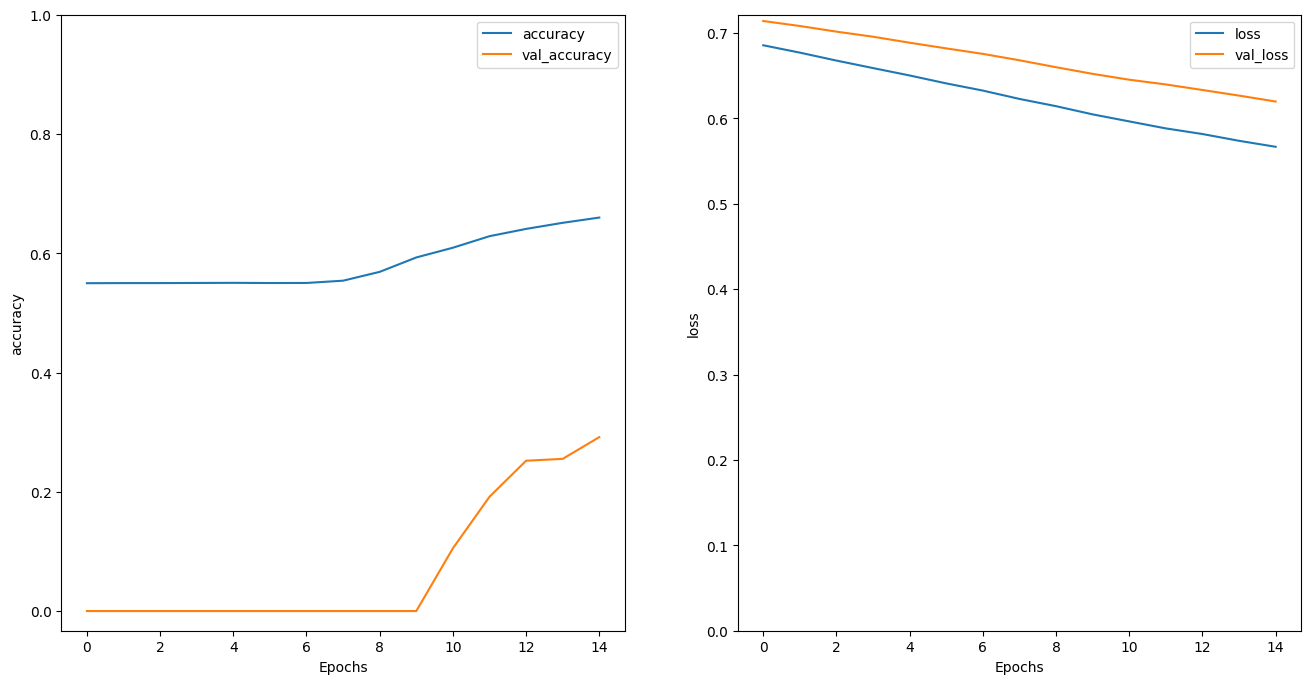

In [36]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [ ]:
# predict on a sample text without padding
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

##### Experiment 2: Use binary count vectorizer for encoding

In [ ]:
model = create_model(encoder_multi_hot)
# predict on a sample formula using untrained model
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

In [ ]:
model.compile(optimizer='sgd',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
configs_dict = {
    "learning_rate": 1e-4,
    "algorithm": "LogReg",
    "configuration": "1-tokens",
    "optimizer": "sgd",
    "loss": "sparse_categorical_crossentropy",
    "epochs": 15,
    "batch_size": 64,
    "vectorizer": "multi_hot",
    "dataset": "TOKENIZED_SET_V1"
}
run = wandb.init(project=wandb_project_name, reinit=True, config=configs_dict)


history = model.fit(train_dataset, epochs=15,
                    validation_data=test_dataset,
                    validation_steps=30,callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [ ]:
# predict on a sample text without padding
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

##### Experiment 3:

In [ ]:
model = create_model(encoder_count)
# predict on a sample formula using untrained model
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

In [ ]:
model.compile(optimizer='sgd',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
configs_dict = {
    "learning_rate": 1e-4,
    "algorithm": "LogReg",
    "configuration": "1-tokens",
    "optimizer": "sgd",
    "loss": "sparse_categorical_crossentropy",
    "epochs": 15,
    "batch_size": 64,
    "vectorizer": "count",
    "dataset": "TOKENIZED_SET_V1"
}
run = wandb.init(project=wandb_project_name, reinit=True, config=configs_dict)


history = model.fit(train_dataset, epochs=15,
                    validation_data=test_dataset,
                    validation_steps=30,callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [ ]:
# predict on a sample text without padding
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

##### Experiment 4:

In [ ]:
model = create_model(encoder_bigrams)
# predict on a sample formula using untrained model
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

In [ ]:
model.compile(optimizer='sgd',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
configs_dict = {
    "learning_rate": 1e-4,
    "algorithm": "LogReg",
    "configuration": "1-tokens",
    "optimizer": "sgd",
    "loss": "sparse_categorical_crossentropy",
    "epochs": 15,
    "batch_size": 64,
    "vectorizer": "bigram_count",
    "dataset": "TOKENIZED_SET_V1"
}
run = wandb.init(project=wandb_project_name, reinit=True, config=configs_dict)


history = model.fit(train_dataset, epochs=15,
                    validation_data=test_dataset,
                    validation_steps=30,callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [ ]:
# predict on a sample text without padding
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

##### Experiment 5:

In [ ]:
model = create_model(encoder_tf_idf)
# predict on a sample formula using untrained model
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

In [ ]:
model.compile(optimizer='sgd',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
configs_dict = {
    "learning_rate": 1e-4,
    "algorithm": "LogReg",
    "configuration": "1-tokens",
    "optimizer": "sgd",
    "loss": "sparse_categorical_crossentropy",
    "epochs": 15,
    "batch_size": 64,
    "vectorizer": "tf_idf",
    "dataset": "TOKENIZED_SET_V1"
}
run = wandb.init(project=wandb_project_name, reinit=True, config=configs_dict)

history = model.fit(train_dataset, epochs=15,
                    validation_data=test_dataset,
                    validation_steps=30,callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [ ]:
# predict on a sample text without padding
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])